In [1]:
#Importing all necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,  precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from openpyxl import load_workbook

In [2]:
#Reading the excel-document into a df
df = pd.read_excel('dataset_name.xlsx')

#dropping unwanted columns from the df
df2=df.drop(columns = ["Column 1", "Column 2"])

In [3]:
#Splitting df into two based on ID
df2["ID"] = df2["ID"].astype(str)  #Making sure its a string
df_train = df2[df2["ID"].isin(["ID 1", "ID 2", "ID 3"])]
df_unseen = df2[df2["ID"] == "ID 4"]

In [4]:
#defining which columns to keep av model input
X = df_train.drop(columns = ['Column 1', 'Column 2', 'Column 3'])

#defining which columns are the model outputs
y = df_train['Column 4']

In [5]:
#Setting up K-Fold cross-validation
k_fold = KFold(n_splits=5, random_state=66, shuffle=True)

#Displaying number of splits
k_fold.get_n_splits(X, y)

#Initializing the Random Forest Classifier
RF = RandomForestClassifier(
    random_state=66,        
    class_weight='balanced' #Handle imbalance between classes
)

#Creating lists to store evaluation metrics from each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []

#Looping over each train-test split in the KFold cross-validation
for train_index, test_index in k_fold.split(X, y):
    #Splitting data into training and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #Skipping the fold if the test set contains only one class
    if len(np.unique(y_test)) == 1:
        print("Skipping this fold due to only one class in test set.")
        continue

    #Initializing a new scaler and applying it to the training and test data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)    #Only fitted on train data
    X_test_scaled = scaler.transform(X_test)          #Transforming the test data on the same scaler

    #Training the Random Forest model on the scaled training data
    RF.fit(X_train_scaled, y_train)

    #Predicting the target values for the test set
    pred_test = RF.predict(X_test_scaled)

    #Calculating and storing classification metrics for this fold
    accuracies.append(accuracy_score(y_test, pred_test))
    precisions.append(precision_score(y_test, pred_test, average='weighted', zero_division=0.0))
    recalls.append(recall_score(y_test, pred_test, average='weighted', zero_division=0.0))
    f1_scores.append(f1_score(y_test, pred_test, average='weighted'))

#Printing the average performance metrics across all valid folds
print(f"Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Mean Precision: {np.mean(precisions):.4f}")
print(f"Mean Recall: {np.mean(recalls):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")

Mean Accuracy: 0.9444 ± 0.0359
Mean Precision: 0.9560
Mean Recall: 0.9444
Mean F1 Score: 0.9454


In [146]:
#Using GridSearchCV to find the best hyperparameters for the Random Forest model

#Defining the hyperparameter grid to search over
parameters_grid = {
    'n_estimators': [75,100,150,300],         #Number of trees in the forest
    'max_features': ['sqrt', 'log2'],         #Strategy to select the number of features at each split 
    'max_depth': [3,6,9,12,15],               #Maximum depth of each tree
    'min_samples_split': [5,10,15],           #Minimum number of samples required to split an internal node
    'min_samples_leaf': [1,3,5,7,9],          #Minimum number of samples required to be at a leaf node
    'criterion': ['entropy', 'gini'],         #Function to measure the quality of a split ('entropy' uses information gain)
    'random_state': [66]                      #Fixed random seed for reproducibility
}

#Setting up the GridSearchCV
CV_RF = GridSearchCV(
    estimator=RF,                    
    param_grid=parameters_grid,      
    cv=k_fold,                        
    scoring='accuracy'               
)

#Fitting the model to the scaled training data using the defined grid
CV_RF.fit(X_train_scaled, y_train)

#Printing the best combination of hyperparameters found during grid search
print('Best parameters: ', CV_RF.best_params_)


Best parameters:  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 100, 'random_state': 66}


In [147]:
#Extracting the best hyperparameters from GridSearchCV
best_params = CV_RF.best_params_

#Initializing the Random Forest model using the best hyperparameters with class_weight = 'balanced' to handle class imbalance
RF_best = RandomForestClassifier(**best_params, class_weight='balanced')

#Fitting the best model to the training data
RF_best.fit(X_train_scaled, y_train)

#Predicting target values on the test set
pred_test = RF_best.predict(X_test_scaled)

#Predicting target values on the training set
pred_train = RF_best.predict(X_train_scaled)

Accuracy: 0.9828
Precision: 0.9831
Recall: 0.9828
F1 Score: 0.9828


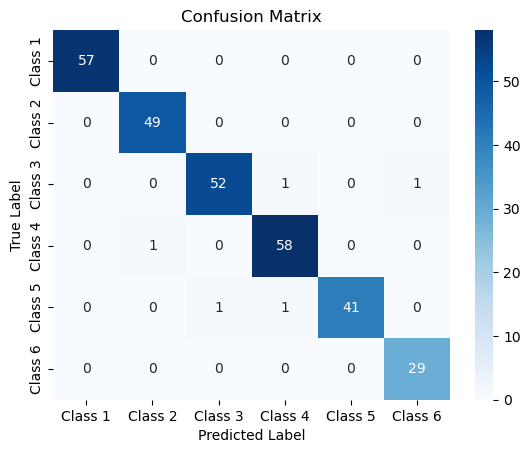

In [148]:
#Calculating performance metrics for classification models
acc_train = accuracy_score(y_train, pred_train)
precision_train = precision_score(y_train, pred_train, average='weighted')
recall_train = recall_score(y_train, pred_train, average='weighted')
f1_train = f1_score(y_train, pred_train, average='weighted')

#Printing the evaluation metrics
print(f'Accuracy: {acc_train:.4f}')
print(f'Precision: {precision_train:.4f}')
print(f'Recall: {recall_train:.4f}')
print(f'F1 Score: {f1_train:.4f}')


#Creating a confusion matrix from true and predicted labels
cm = confusion_matrix(y_train, pred_train)

#Defining class labels
class_labels = [f"Class {i}" for i in np.unique(y_train)]

#Plotting the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


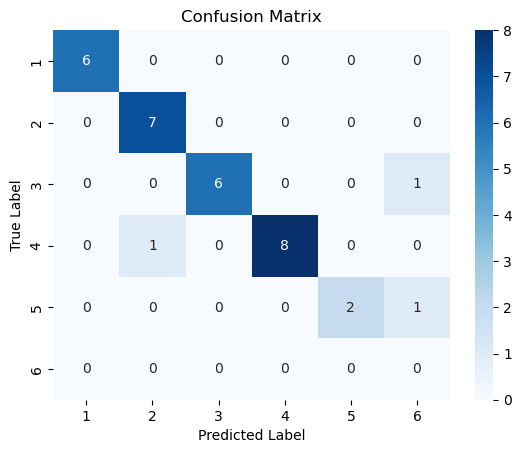

Accuracy: 0.9062
Precision: 0.9727
Recall: 0.9062
F1 Score: 0.9333


In [149]:
#Calculating performance metrics based on the test data
acc_test = accuracy_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test, average='weighted')
recall_test = recall_score(y_test, pred_test, average='weighted', zero_division=0.0) #zero_division=0.0 handles cases where a class is not predicted at all
f1_test = f1_score(y_test, pred_test, average='weighted')

#Printing all test metrics
print(f'Accuracy: {acc_test:.4f}')
print(f'Precision: {precision_test:.4f}')
print(f'Recall: {recall_test:.4f}')
print(f'F1 Score: {f1_test:.4f}')

#Ensuring consistency in the confusion matrix even if some classes are missing in y_test
all_labels = np.unique(y)

#Computing the confusion matrix using all possible class labels
cm = confusion_matrix(y_test, pred_test, labels=all_labels)

#Plotting the confusion matrix as a heatmap for easier visual interpretation
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=all_labels, yticklabels=all_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Accuracy: 0.2966
Precision: 0.1947
Recall: 0.2966
F1 Score: 0.2203


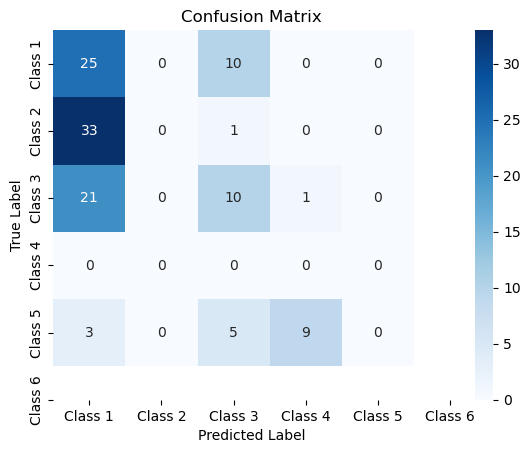

Confusion Matrix:
 [[25  0 10  0  0]
 [33  0  1  0  0]
 [21  0 10  1  0]
 [ 0  0  0  0  0]
 [ 3  0  5  9  0]]


In [150]:
#defining inputs and outputs for unseen dataset
X_unseen = df_unseen.drop(columns = ['Column 1', 'Column 2', 'Column 3')
y_unseen = df_unseen['Column 4']                               

#Scaling the unseen data using the same scaler fitted on the training data
X_unseen_scaled = scaler.transform(X_unseen)                      

#Making predictions on the unseen data using the trained and tuned Random Forest model
y_pred_unseen = RF_best.predict(X_unseen_scaled)

#Evaluating model performance on the unseen data
acc_unseen = accuracy_score(y_unseen, y_pred_unseen)                    
precision_unseen = precision_score(y_unseen, y_pred_unseen, average='weighted', zero_division=0) 
recall_unseen = recall_score(y_unseen, y_pred_unseen, average='weighted', zero_division=0)
f1_unseen = f1_score(y_unseen, y_pred_unseen, average='weighted', zero_division=0)

#Printing evaluation metrics
print(f'Accuracy: {acc_unseen:.4f}')
print(f'Precision: {precision_unseen:.4f}')
print(f'Recall: {recall_unseen:.4f}')
print(f'F1 Score: {f1_unseen:.4f}')


#Generating the confusion matrix
cm_unseen = confusion_matrix(y_unseen, y_pred_unseen)

#Createing readable class labels based on training classes
class_labels = [f"Class {i}" for i in np.unique(y_train)]

#Plotting confusion matrix as heatmap
sns.heatmap(cm_unseen, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [152]:
def log_results(model_name, params, accuracy_train, precision_train, recall_train, f1_train,
                accuracy_test, precision_test, recall_test, f1_test,
                accuracy_unseen, precision_unseen, recall_unseen, f1_unseen,
                filename="Excel_name.xlsx"):
    """ Logs classification model results in separate sheets within the same Excel file, ensuring appending works correctly. """

    #Creating DataFrame for this model run
    result = pd.DataFrame([{
        **params,  # Store hyperparameters
        "Accuracy_Train": accuracy_train,
        "Precision_Train": precision_train,
        "Recall_Train": recall_train,
        "F1_Train": f1_train,
        "Accuracy_Test": accuracy_test,
        "Precision_Test": precision_test,
        "Recall_Test": recall_test,
        "F1_Test": f1_test,
        "Accuracy_Unseen": accuracy_unseen,
        "Precision_Unseen": precision_unseen,
        "Recall_Unseen": recall_unseen,
        "F1_Unseen": f1_unseen
    }])

    #Introducing a short delay to avoid file conflicts if running in multiple notebooks
    time.sleep(1)

    #Checking if the file exists
    file_exists = os.path.exists(filename)

    if not file_exists:
        #If file doesn't exist, creating a new one
        with pd.ExcelWriter(filename, engine="openpyxl", mode="w") as writer:
            result.to_excel(writer, sheet_name=model_name, index=False)
    else:
        #If file exists, loading it properly before appending
        try:
            with pd.ExcelWriter(filename, engine="openpyxl", mode="a", if_sheet_exists="overlay") as writer:
                # Read existing sheet (if it exists)
                try:
                    existing_df = pd.read_excel(filename, sheet_name=model_name, engine="openpyxl")
                    df_combined = pd.concat([existing_df, result], ignore_index=True)
                except (FileNotFoundError, ValueError):
                    df_combined = result  # If sheet does not exist, create it

                # Save results, ensuring correct appending
                df_combined.to_excel(writer, sheet_name=model_name, index=False)

        except PermissionError:
            print(f"Error: Close the Excel file ({filename}) before running the script again.")

    print(f"Logged results for {model_name}: Train Accuracy={accuracy_train:.4f}, Test Accuracy={accuracy_test:.4f}, Unseen Accuracy={accuracy_unseen:.4f}")



In [153]:
log_results(
    model_name="RF-Kfold",
    params=best_params,

    accuracy_train=acc_train,
    precision_train=precision_train,
    recall_train=recall_train,
    f1_train=f1_train,

    accuracy_test=acc_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1_test=f1_test,

    accuracy_unseen=acc_unseen,
    precision_unseen=precision_unseen,
    recall_unseen=recall_unseen,
    f1_unseen=f1_unseen
)


Logged results for RF-Kfold: Train Accuracy=0.9828, Test Accuracy=0.9062, Unseen Accuracy=0.2966
